In [8]:
import pandas as pd
import numpy as np
import pickle
import sys
import datetime as dt
from dateutil.relativedelta import *
from collections import Counter
from collections import defaultdict
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc,confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from pandas_profiling import profile_report
import seaborn as sns
import matplotlib.pyplot as plt
from src.utils import FrequencyEncoder,ks_table
from category_encoders.ordinal import OrdinalEncoder
from category_encoders.target_encoder import TargetEncoder
from sklearn.metrics import precision_recall_curve
import xgboost as xgb
import lightgbm as lgb
import shap

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', 500)

/opt/homebrew/lib/python3.10/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/opt/homebrew/lib/python3.10/site-packages/visions/backends/shared/nan_handling.py:51: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def hasna(x: np.ndarray) -> bool:
/var/folders/tk/x3_nwj8533d75chf2_40wmy80000gn/T/ipykernel_14411/15791649.py:16: DeprecationWarning: `import pandas_profiling` is going to be depreca

# Import data

In [9]:
booking_data=pd.read_csv('data/in/booking_data.csv')
booking_data.head()

,id,lead_time,arrival_week,duration,prev_cancel,booking_changes,waiting_period,per_day_price,parking,special_request,segment,deposit,cust_type,is_cancelled
0,7e4be0a6-8ccb-4640-a758-d1944eca6a90,211,7,18,1,1,8,179.24,0,2,Offline TA/TO,No Deposit,Transient,1
1,4e2a0421-35df-4304-add8-30fc7de0fab3,178,31,18,18,9,21,165.65,0,2,Online TA,Refundable,Transient,0
2,15dd1501-f89e-4d44-9189-412f720ebbe8,309,20,18,0,0,7,258.12,1,3,Complementary,Refundable,Transient-Party,0
3,d36f0853-9ef4-4110-b5b7-37bd1e6f200e,99,11,18,0,0,5,153.58,0,2,Complementary,Refundable,Transient-Party,0
4,fa47f667-8efc-4aea-876c-3d561668cdc2,193,2,18,18,10,13,113.24,0,2,Online TA,Refundable,Transient,0


In [10]:
booking_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               3000 non-null   object 
 1   lead_time        3000 non-null   int64  
 2   arrival_week     3000 non-null   int64  
 3   duration         3000 non-null   int64  
 4   prev_cancel      3000 non-null   int64  
 5   booking_changes  3000 non-null   int64  
 6   waiting_period   3000 non-null   int64  
 7   per_day_price    3000 non-null   float64
 8   parking          3000 non-null   int64  
 9   special_request  3000 non-null   int64  
 10  segment          3000 non-null   object 
 11  deposit          3000 non-null   object 
 12  cust_type        3000 non-null   object 
 13  is_cancelled     3000 non-null   int64  
dtypes: float64(1), int64(9), object(4)
memory usage: 328.2+ KB


# Data Transformation Steps

## 0. EDA with Pandas profilling

In [11]:
profile=booking_data.profile_report(
        title='Pandas profiling Report',
        correlations={'spearman':{'calculate':True},
        'pearson':{'calculate':True}},
        interactions={'targets':['is_cancelled'],'continuous':True}
        #,minimal=True
        #,explorative=True
        )

In [12]:
profile.to_file('eda_profiling_.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

## 1. New variable

In [13]:
booking_data['total_cost'] = booking_data['duration'] * booking_data['per_day_price']

## 2.Encode categorical variables

In [14]:
categorical_features = ['segment', 'deposit', 'cust_type']
booking_data_encoded = pd.get_dummies(booking_data, columns=categorical_features, drop_first=True)

## 3.Check correlation

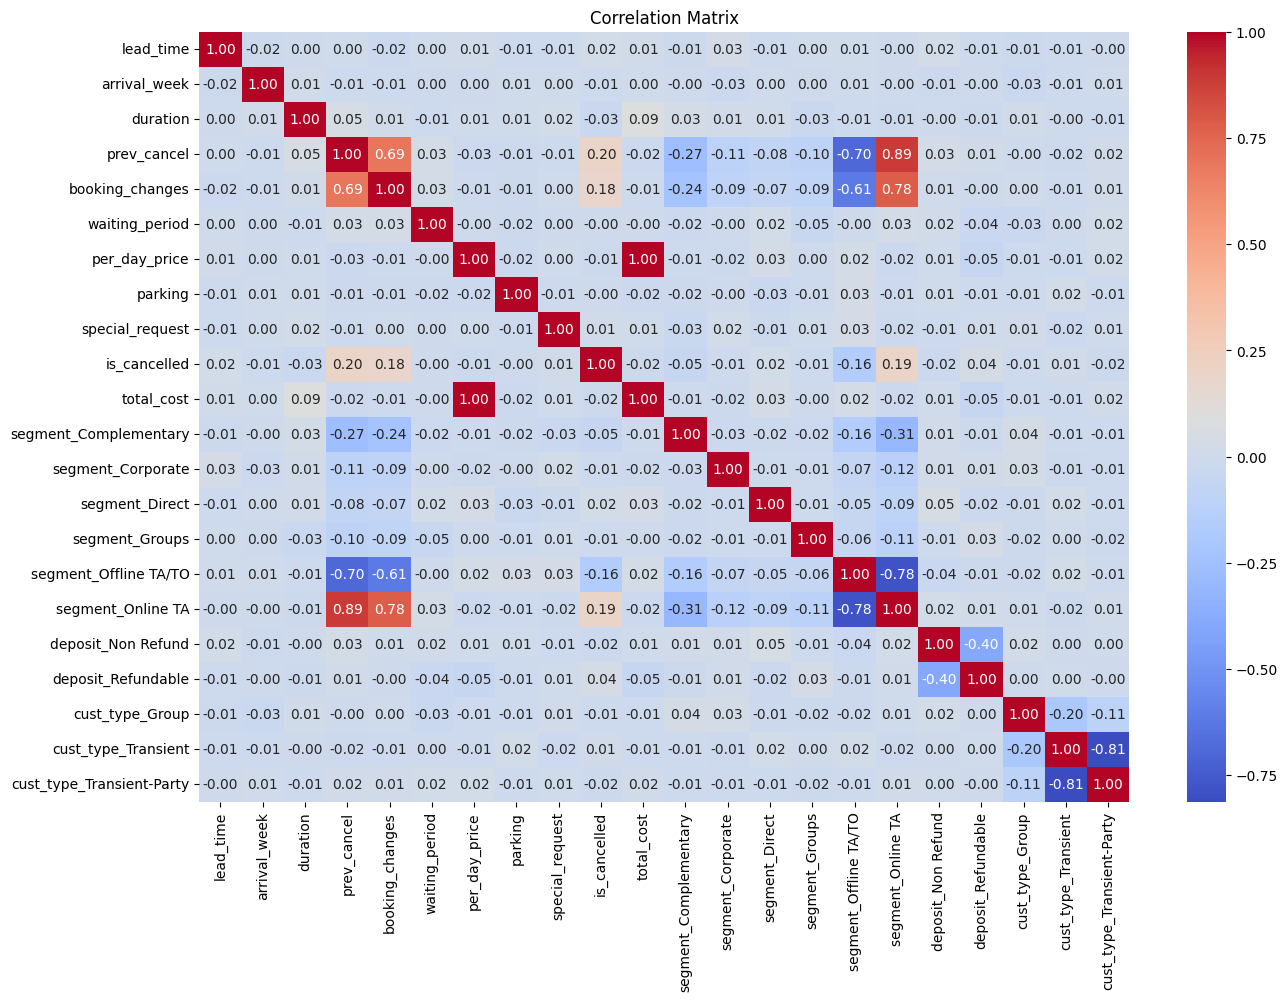

In [21]:
# Correlation Analysis
correlation_matrix = booking_data_encoded.drop(columns=['id']).corr()

# Visualizing the correlation matrix
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [22]:
# Selecting top features based on correlation analysis
selected_features = ['lead_time', 'booking_changes', 'prev_cancel', 'waiting_period', 
                     'total_cost', 'special_request', 'segment_Offline TA/TO', 
                     'segment_Online TA', 'deposit_Non Refund', 'deposit_Refundable', 
                     'cust_type_Group', 'cust_type_Transient', 'cust_type_Transient-Party']

X = booking_data_encoded[selected_features]
y = booking_data_encoded['is_cancelled']

# Key findings

- lead_time, booking_changes, prev_cancel, and waiting_period showed notable correlations with is_cancelled.
- per_day_price and duration were moderately correlated, indicating that higher prices and longer stays might influence cancellation rates.

# Modeling

In [23]:
# Splitting the data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Random forest

In [24]:
# Training a RandomForest Classifier
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [25]:
# Predicting on the test set
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

In [26]:
# Model Evaluation
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)
fpr, tpr, _ = roc_curve(y_test, y_prob)

# Displaying results
print(f"Accuracy: {accuracy}")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Classification Report:\n{class_report}")
print(f"ROC AUC: {roc_auc}")

Accuracy: 0.73
Confusion Matrix:
[[539  65]
 [178 118]]
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.89      0.82       604
           1       0.64      0.40      0.49       296

    accuracy                           0.73       900
   macro avg       0.70      0.65      0.65       900
weighted avg       0.72      0.73      0.71       900

ROC AUC: 0.8159315151243959


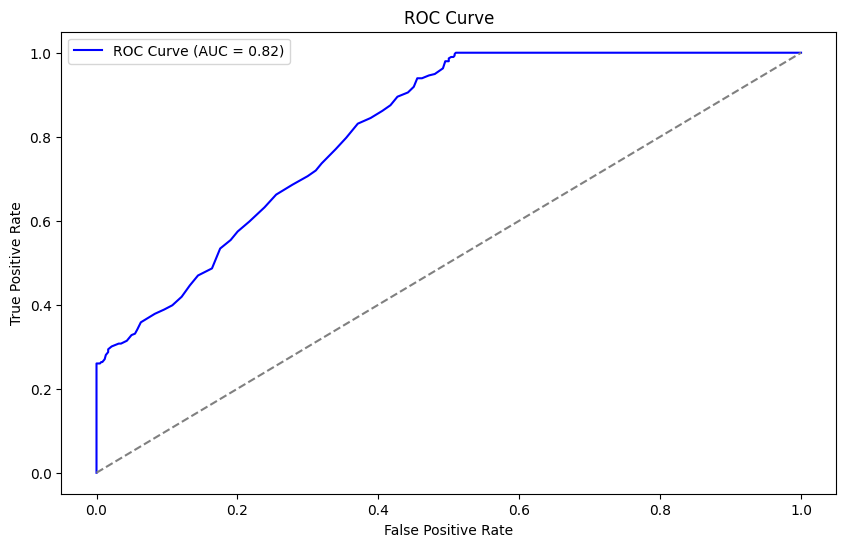

In [27]:
# Plotting ROC Curve
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [28]:
# Feature Importance
feature_importance = model.feature_importances_
features_df = pd.DataFrame({'Feature': selected_features, 'Importance': feature_importance})
features_df = features_df.sort_values(by='Importance', ascending=False)

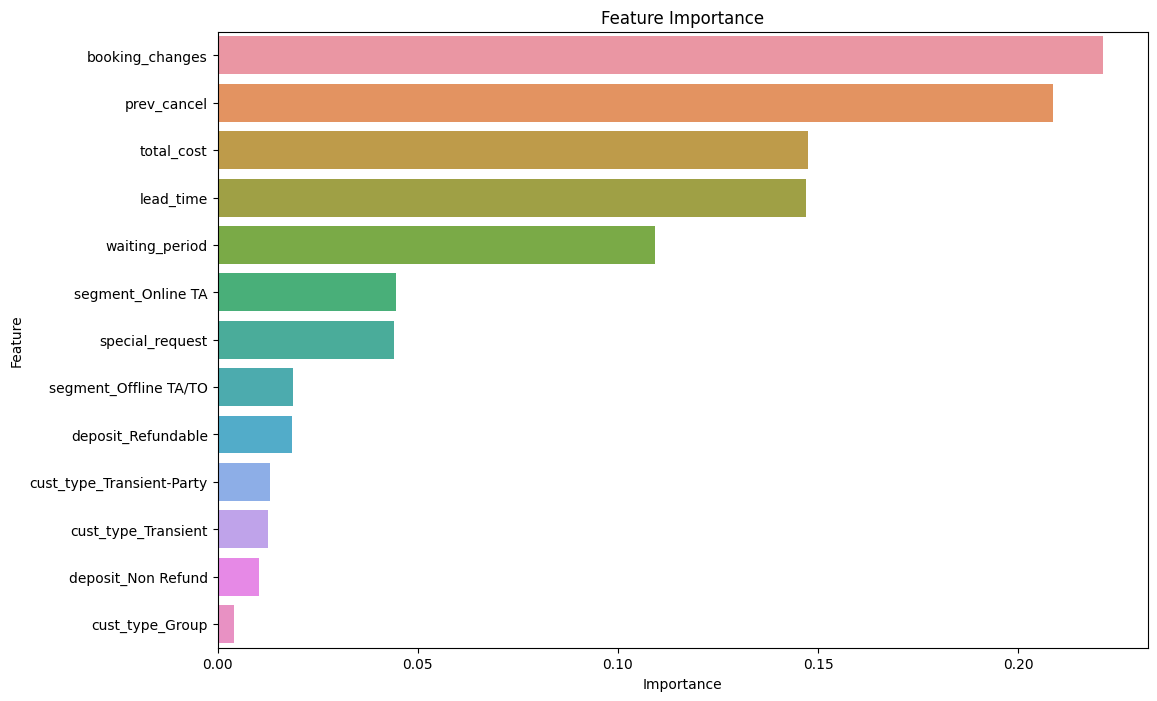

In [29]:
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=features_df)
plt.title('Feature Importance')
plt.show()

## Feature importance analysis

The feature importance analysis reveals the most influential features for predicting cancellations. The top features are:

1. booking_changes: Indicates the number of changes made to the booking.
2. prev_cancel: Reflects the number of previous cancellations by the customer.
3. total_cost: The total cost of the booking.
4. lead_time: Time between booking and reservation date.
5. waiting_period: The waiting period for booking confirmation.
These features significantly impact the model's predictions, providing valuable insights into customer behavior and potential reasons for cancellations.

## Conclusion

- The RandomForest Classifier performed well, with a good balance of precision and recall.
- The ROC curve demonstrates the model's ability to distinguish between cancellations and non-cancellations, with an AUC score indicating a high level of accuracy.